### Import Dataset

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Dataset yolunu belirt
dataset_path = '/aı_datasets/Real_Life_Violence_Dataset'

# Sınıf isimleri ve etiketleri
class_map = {"Violence": 1, "NonViolence": 0}

# 1. Veri dosyalarını topla
videos = []
labels = []

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for file_name in os.listdir(class_dir):
        if file_name.endswith(("mp4", ".avi", ".mov")):
            video_path = os.path.join(class_dir, file_name)
            videos.append(video_path)
            labels.append(class_map[class_name])

print(f"Toplam video sayısı: {len(videos)}")

Toplam video sayısı: 2000


### Data Preprocessing

In [2]:

def extract_frames(video_path, max_frames=30, gray=True, resize=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    count = 0
    while count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if gray:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, resize)
        frames.append(frame)
        count += 1
    cap.release()

    if gray:
        frames = [frame[..., np.newaxis] for frame in frames]
    frames = np.array(frames)

    if frames.shape[0] < max_frames:
        pad_count = max_frames - frames.shape[0]
        padding = np.zeros((pad_count, resize[0], resize[1], 1))
        frames = np.concatenate((frames, padding), axis=0)

    return frames

In [3]:
X = []
y = []

for video_path, label in zip(videos, labels):
    frames = extract_frames(video_path, max_frames=30)
    X.append(frames)
    y.append(label)

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

In [4]:
# 4. Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim örnek sayısı: {len(X_train)}")
print(f"Test örnek sayısı: {len(X_test)}")


Eğitim örnek sayısı: 1600
Test örnek sayısı: 400


### Model

In [22]:
input_shape = (30, 224, 224, 1)

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling3D(pool_size=(1, 2, 2)),

    layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),



    layers.GlobalAveragePooling3D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)              │ (None, 30, 224, 224,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 30, 224, 224,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 30, 112, 112,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_21 (Conv3D)              │ (None, 30, 112, 112,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 30, 112, 112,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 15, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_22 (Conv3D)              │ (None, 15, 56, 56,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 15, 56, 56,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 7, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 7, 28, 28, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 7, 28, 28, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 3, 14, 14, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,230,529 (4.69 MB)

 Trainable params: 1,229,569 (4.69 MB)

 Non-trainable params: 960 (3.75 KB)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint('model7.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# 7. Modeli eğit
history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/70
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9371 - loss: 0.1752

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9371 - loss: 0.1753 - val_accuracy: 0.8900 - val_loss: 0.2942 - learning_rate: 8.0000e-06
Epoch 2/70
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9188 - loss: 0.2082 - val_accuracy: 0.8875 - val_loss: 0.2991 - learning_rate: 8.0000e-06
Epoch 3/70
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9401 - loss: 0.1710 - val_accuracy: 0.8850 - val_loss: 0.2955 - learning_rate: 8.0000e-06
Epoch 4/70
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9284 - loss: 0.1952
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.9284 - loss: 0.1952 - val_accuracy: 0.8825 - val_loss: 0.2956 - learning_rate: 8.0000e-06
Epoch 5/70
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9283 - loss: 0.1891 - val_accuracy: 0.8975 - val_loss: 0.2974 - learning_rate: 1.6000e-06
Epoch 6/70
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accur

In [6]:
from tensorflow.keras.models import load_model

load = load_model('model6.h5')
loss, accuracy = load.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test(Accuracy): {accuracy:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 168s 13s/step - accuracy: 0.9316 - loss: 0.1904
Test Loss: 0.1807
Test(Accuracy): 0.9350


13/13 ━━━━━━━━━━━━━━━━━━━━ 167s 13s/step
              precision    recall  f1-score   support

      Normal       0.92      0.93      0.93       199
     Violent       0.93      0.92      0.93       201

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



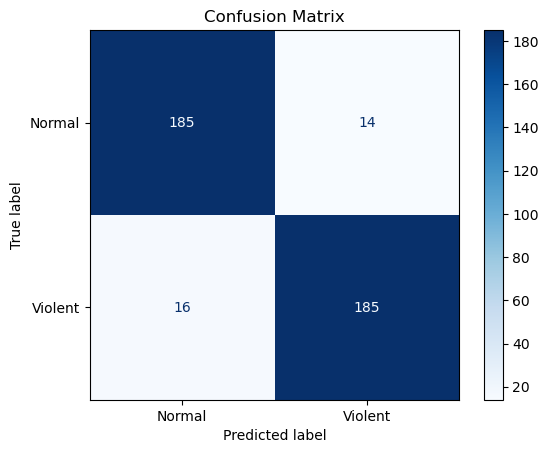

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



y_pred_probs = load.predict(X_test)
y_pred = (y_pred_probs > 0.6).astype("int32")


print(classification_report(y_test, y_pred, target_names=['Normal', 'Violent']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violent'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Predicteing on video

In [46]:
def predict_video(model, video_path, input_shape=(60, 224,224), frame_skip=1):
    cap = cv2.VideoCapture(video_path)
    frames = []
    predictions = []

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            resized = cv2.resize(frame, (input_shape[1], input_shape[2]))
            gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
            norm = gray / 255.0
            frames.append(norm)

            if len(frames) == input_shape[0]:
                input_frames = np.array(frames).reshape(1, *input_shape, 1)
                prob= model.predict(input_frames)[0][0]
                predictions.append(prob)

                label = f"Violence : {prob*100:.1f}%"
                color = (0, 255, 0) if prob < 0.5 else (0, 0 , 255)
                cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                cv2.rectangle(frame, (5,5), (200, 50), color, 2)

                cv2.imshow("Frame", frame)
                
                if cv2.waitKey(30) & 0xFF == ord('q'):
                    break

                frames = []
        
        frame_count +=1

    
    cap.release()
    cv2.destroyAllWindows()


video_path = "/Desktop/X7.mp4"
predict_video(load, video_path)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


### Predicteing on camera (Real Time)

In [45]:
import cv2
import numpy as np
import time

IMG_HEIGHT = 224
IMG_WIDTH = 224
SEQUENCE_LENGTH = 20
CHANNELS = 1  

frame_buffer = []

try:
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Kamera açılamadı.")
        exit()

    while True:
        try:
            ret, frame = cap.read()
            if not ret:
                print("Kameradan görüntü alınamıyor.")
                break

            time.sleep(0.05) 

            try:
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            except Exception as e:
                print(f"Renk dönüşümü hatası: {e}")
                continue  

            try:
                resized = cv2.resize(gray, (IMG_WIDTH, IMG_HEIGHT))
            except Exception as e:
                print(f"Resize hatası: {e}")
                continue

            processed = np.expand_dims(resized, axis=-1)
            frame_buffer.append(processed)

            if len(frame_buffer) == SEQUENCE_LENGTH:
                try:
                    input_data = np.array(frame_buffer, dtype=np.float32) / 255.0
                    input_data = np.expand_dims(input_data, axis=0)

                    prediction = load.predict(input_data)[0][0]
                    score = float(prediction)

                    label = f"Violence Score: {score:.2f}"
                    print(label)

                    color = (0, 255, 0) if score < 0.5 else (0, 0, 255)

                    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    cv2.rectangle(frame, (5, 5), (frame.shape[1] - 5, frame.shape[0] - 5), color, 3)

                except Exception as e:
                    print(f"Tahmin hatası: {e}")

                frame_buffer = []

            cv2.imshow('Violence Detection', frame)

            

        except Exception as e:
            print(f"Döngü içi genel hata: {e}")

except Exception as e:
    print(f"Genel hata: {e}")

finally:
    cap.release()
    cv2.destroyAllWindows()
    print("Program sonlandırıldı ve kaynaklar temizlendi.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Violence Score: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Violence Score: 0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Violence Score: 0.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Violence Score: 0.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Violence Score: 0.17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Violence Score: 0.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Violence Score: 0.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Violence Score: 0.11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Violence Score: 0.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Violence Score: 0.22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Violence Score: 0.11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Violence Score: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Violence Score: 0.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Violence Score: 0.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Violence Score: 0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Violence Score: 0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
V

KeyboardInterrupt: 